# Causal Inference in Decision Intelligence – Part 16: Heterogeneous Effects, Segmentation, and Targeting

Link to the article:  [Heterogenious Effects, Segmentation and Targeting](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-16-effects-zinoviev-hap1c)

## Generate the data

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from dowhy.utils import plot

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Display numbers with 2 decimal points
pd.options.display.float_format='{:,.2f}'.format

In [2]:
np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})
#data["Income"] = data.Income.replace({1: "Low", 2: "Medium", 3: "High"})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create Promo variable 
data['Market'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Market + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + np.random.normal(loc=0, scale=5, size=4000)

data.sample(10)

,Year,Id,Income,Macro,Price,Market,Visits,Sales
51,2020,52,1,1,11.59,71.58,7.03,70.60
3582,2023,583,1,0,10.38,83.36,8.43,59.31
1130,2021,131,1,0,10.37,83.61,8.15,55.09
2927,2022,928,1,1,11.18,73.53,7.13,69.32
23,2020,24,1,1,11.02,71.21,7.70,73.25
3444,2023,445,3,0,10.20,81.61,8.89,81.92
1250,2021,251,3,0,10.08,81.16,8.39,90.93
2410,2022,411,3,1,12.04,73.52,7.71,105.04
1451,2021,452,1,0,9.69,80.86,8.19,61.90
1148,2021,149,2,0,9.96,81.99,7.27,69.46


## Build the directed Acyclic Graph

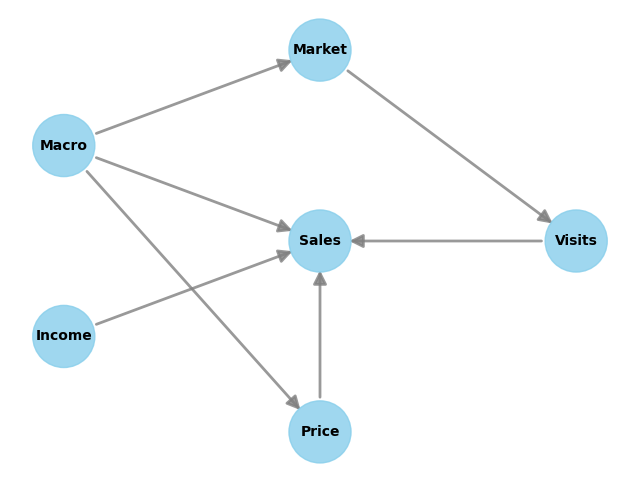

In [3]:
# Create the true DAG
G_part = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Market'), 
                  ('Income', 'Sales'), ('Price', 'Sales'), ('Market', 'Visits'), ('Visits', 'Sales')])
plt.rcParams['font.size'] = 10
plot(G_part, figure_size=[8, 6])

## Find the Optimal Price

In [4]:
# Estimate the effect of the variables on Sales 
model = smf.ols('Sales ~ Price + Macro + Visits + Price + Income', data).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,79.1840,2.075,38.169,0.000,75.117,83.251
Price,-7.0220,0.160,-43.756,0.000,-7.337,-6.707
Macro,28.0862,0.392,71.612,0.000,27.317,28.855
Visits,4.0811,0.158,25.758,0.000,3.771,4.392
Income,14.2159,0.111,128.259,0.000,13.999,14.433


In [5]:
# Group by the data by Income and Macro and calculate the average values of Price and Visits
df_coef = data.groupby(['Income', 'Macro'])[['Price', 'Visits']].mean().reset_index()
df_coef

,Income,Macro,Price,Visits
0,1,0,9.98,8.16
1,1,1,11.96,7.18
2,2,0,9.98,8.25
3,2,1,12.00,7.19
4,3,0,9.96,8.20
5,3,1,11.98,7.19


In [6]:
# Use the above-generated features to predict Sales
df_coef["Sales"] = model.predict(df_coef)
df_coef

,Income,Macro,Price,Visits,Sales
0,1,0,9.98,8.16,56.66
1,1,1,11.96,7.18,66.83
2,2,0,9.98,8.25,71.22
3,2,1,12.00,7.19,80.79
4,3,0,9.96,8.20,85.38
5,3,1,11.98,7.19,95.14


In [7]:
# Calculate Profit assuming production cost equal 2
cost = 2
df_coef["Profit"] = df_coef.Sales * (df_coef.Price - cost)
df_coef

,Income,Macro,Price,Visits,Sales,Profit
0,1,0,9.98,8.16,56.66,451.98
1,1,1,11.96,7.18,66.83,665.45
2,2,0,9.98,8.25,71.22,568.07
3,2,1,12.00,7.19,80.79,807.87
4,3,0,9.96,8.20,85.38,679.52
5,3,1,11.98,7.19,95.14,949.55


In [9]:
# Extract the coefficients of the model
coef = dict(model.params)
coef = pd.DataFrame([coef]).T.reset_index().rename(columns={"index": "Feature", 0: "Coefficient"})

coef

,Feature,Coefficient
0,Intercept,79.18
1,Price,-7.02
2,Macro,28.09
3,Visits,4.08
4,Income,14.22


In [10]:
# Calculate the optimal price by finding the derivative of Profit by Price, equalize it to 0 and solve the equation
np.random.seed(3)
df_coef_opt = df_coef[['Income', 'Macro', 'Price', 'Visits']]
def optimal_price(row):
    macro = row['Macro']
    income = row['Income']
    price = row['Price']
    visits = row['Visits']
    
    return (coef.iloc[0,1] + coef.iloc[4,1] * income + coef.iloc[3,1] * visits + coef.iloc[2,1] * macro - coef.iloc[1,1] * cost) / (-2 * coef.iloc[1,1])
        
# Apply the function to create Optimal price column
df_coef_opt['Price'] = df_coef_opt.apply(optimal_price, axis=1)

df_coef_opt

,Income,Macro,Price,Visits
0,1,0,10.02,8.16
1,1,1,11.74,7.18
2,2,0,11.06,8.25
3,2,1,12.75,7.19
4,3,0,12.06,8.20
5,3,1,13.76,7.19


In [12]:
# Calculate the optimal Sales and Profit
df_coef_opt["Sales_opt"] = model.predict(df_coef_opt)
df_coef_opt["Profit_opt"] = df_coef_opt.Sales_opt * (df_coef_opt.Price - cost)
df_coef_opt

,Income,Macro,Price,Visits,Sales_opt,Profit_opt
0,1,0,10.02,8.16,56.34,451.99
1,1,1,11.74,7.18,68.38,665.79
2,2,0,11.06,8.25,63.61,576.30
3,2,1,12.75,7.19,75.50,811.84
4,3,0,12.06,8.20,70.63,710.49
5,3,1,13.76,7.19,82.61,971.90


In [13]:
# Add profit comparison to the dataset
df_coef_opt['Profit'] = df_coef.Profit
df_coef_opt['Profit_growth'] = df_coef_opt.Profit_opt - df_coef_opt.Profit
df_coef_opt

,Income,Macro,Price,Visits,Sales_opt,Profit_opt,Profit,Profit_growth
0,1,0,10.02,8.16,56.34,451.99,451.98,0.02
1,1,1,11.74,7.18,68.38,665.79,665.45,0.34
2,2,0,11.06,8.25,63.61,576.30,568.07,8.23
3,2,1,12.75,7.19,75.50,811.84,807.87,3.98
4,3,0,12.06,8.20,70.63,710.49,679.52,30.97
5,3,1,13.76,7.19,82.61,971.90,949.55,22.34


In [14]:
# Calculate the optimal price
pt1= round(pd.pivot_table(df_coef_opt, values="Price", index="Income", columns="Macro", aggfunc="mean"), 2)
print(pt1)

Macro      0     1
Income            
1      10.02 11.74
2      11.06 12.75
3      12.06 13.76


In [15]:
# Calculate the total annual profit improvement
Total_profit_growth_macro0 = 500 * df_coef_opt.iloc[0,7] + 350 * df_coef_opt.iloc[2,7] + 150 * df_coef_opt.iloc[4,7]
Total_profit_growth_macro1 = 500 * df_coef_opt.iloc[1,7] + 350 * df_coef_opt.iloc[3,7] + 150 * df_coef_opt.iloc[5,7]
print(f'Total annual profit improvement for a bad year (Macro=0): ${round(Total_profit_growth_macro0, 2)}')
print(f'Total annual profit improvement for a good year (Macro=1): ${round(Total_profit_growth_macro1, 2)}')

Total annual profit improvement for a bad year (Macro=0): $7534.04
Total annual profit improvement for a good year (Macro=1): $4913.32
